In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pylab as plt

import time
import rascal

import ase
from ase import Atoms
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
from numpy.testing import assert_allclose
import numpy as np

from scipy.integrate import quad
from pylode.lib.radial_basis import innerprod
from scipy.special import gamma, hyp1f1, sph_harm, iv

# Descriptor related imports: compare the librascal and pyLODE versions of SOAP
import rascal.representations
import rascaline
from pylode.lib.projection_coeffs import DensityProjectionCalculator

# Introduction

This notebook is used to compare the features obtained from rascaline, librascal and pylode. The goal is to fully understand the details of the three implementations to make sure that the same coefficients from different codes agree.

## Table of Contents:
* [Preparation](#preparation)
    * [Exact Expression for Coefficients](#exactexpressions)
    * [Get the features for dimers](#getfeatures)
* [Coefficients for $l=1$](#l=1)
    * [Explicit computation of coefficients for $l=1$](#l=1explicit)
    * [Comparison to pyLODE/rascal for dimers](#l=1dimer)
* [Coefficients for $l\geq 2$](#lgeq2)
    * [Coefficients for $l=2$](#l=2)
    * [Coefficients for general $l$](#l_general)
* [Coefficients for l=0](#l=0)
    * [Exact coefficients](#l=0exact)
    * [Comparison to pyLODE/rascal for center contribution](#l=0center)
    * [Comparison to pyLODE/rascal for dimers](#l=0dimer)

# Preparation: Get features from all three codes <a class="anchor" id="preparation"></a>

## Exact Expression for Coefficients <a class="anchor" id="exactexpressions"></a>

### Define common hyperparameters

In [3]:
nmax = 5
lmax = 5
rcut = 6.
smearing = 0.5

### Generate orthonormalization matrix <a class="anchor" id="orthonormalization"></a>

In [4]:
Nradial = 1000
sigma = np.ones(nmax, dtype=float)
for i in range(1, nmax):
    sigma[i] = np.sqrt(i)
sigma *= rcut / nmax

# Define primitive GTO-like radial basis functions
f_gto = lambda n, x: x**n * np.exp(-0.5 * (x / sigma[n])**2)
xx = np.linspace(0, rcut * 2.5, Nradial)
R_n = np.array([f_gto(n, xx) for n in range(nmax)])

# Orthonormalize
innerprods = np.zeros((nmax, nmax))
for i in range(nmax):
    for j in range(nmax):
        innerprods[i, j] = innerprod(xx, R_n[i], R_n[j])
eigvals, eigvecs = np.linalg.eigh(innerprods)
transformation = eigvecs @ np.diag(np.sqrt(1. / eigvals)) @ eigvecs.T

### Fully analytical formula for general $l$

In [5]:
def coefficients_analytical_general_l(nmax, d, l):
    # Define auxilary quantities and prefactors
    a = 1. / (2 * smearing**2)
    lplus3half = l + 1.5
    prefac_global = np.pi**1.5 * sph_harm(0, l, 0, 0).real * a / gamma(lplus3half)
    prefac_global *= d * np.exp(-a*d**2)
    prefac_global /= (2 * np.pi * smearing**2)**1.5

    # Start main loop
    featvec = np.zeros((nmax))
    for n in range(nmax):
        nlplus3half = (3 + n + l) / 2
        b = 1. / (2 * sigma[n]**2)
        prefac_n_dep = gamma(nlplus3half) / (a+b)**nlplus3half
        hyp = hyp1f1(nlplus3half, lplus3half, a**2*d**2/(a+b))
        featvec[n] = prefac_n_dep * hyp

    return prefac_global * (transformation @ featvec)   

### Semianalytical (final integral performed numerically) formula for general l

In [6]:
def coefficients_semianalytical_general_l(nmax, d, l):
    # Prefactor
    a = 1. / (2 * smearing**2)
    prefac_global = 4*np.pi * sph_harm(0, l, 0, 0).real * np.exp(-a*d**2)
    prefac_global /= (2 * np.pi * smearing**2)**1.5

    # Main loop performing the numerical integration
    featvec = np.zeros((nmax))
    for n in range(nmax):
        # Define the integrand consisting of a power-law, Gaussian and Bessel part
        b = 1. / (2 * sigma[n]**2)
        gaussian = lambda r: np.exp(-(a+b)*r**2)
        power = lambda r: r**(2+n)
        mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
        bessel = lambda r: mod_sph_bessel(2*a*d*r)
        integrand = lambda r: power(r) * gaussian(r) * bessel(r)
        
        # Numerical integration
        eps = 1e-10
        featvec[n] = quad(integrand, eps, 4.5*rcut)[0]

    return prefac_global * (transformation @ featvec)   

## Get the features for dimers <a class="anchor" id="getfeatures"></a>

### Define structure to be used for the comparison
The main differences between librascal and the pyLODE implementation are the presence of a smooth cutoff function and the potentially different order in which neighbors are stored. We thus wish to generate structures for which these two effects do not alter the coefficients too much. For this task, we use clusters of Oxygen atoms for which all atoms have a mutual distance of less than 3A. Then, even for a relatively large smearing of 1.5A, the atomic densities will be reasonably contained within a ball of cutoff radius 6 that will also be used for the cutoff.

In [7]:
frames = []
cell = np.eye(3) * 16
distances = np.linspace(1., 2.5, 10)
for d in distances:
    positions = [[1,1,1],[1+0.1*d,1+d,d+1]]
    positions = [[1,1,1],[1,1,1+d]]
    frame = Atoms('O2', positions=positions, cell=cell, pbc=True)
    frames.append(frame)

### Get the features from librascal

In [8]:
# define the parameters of the spherical expansion
hypers = dict(interaction_cutoff=rcut, 
              max_radial=nmax, 
              max_angular=lmax, 
              gaussian_sigma_constant=smearing,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.1,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              )

calculator_librascal = rascal.representations.SphericalExpansion(**hypers)
# compute the representation of all the structures
features_librascal = calculator_librascal.transform(frames).get_features(calculator_librascal)

### Get the features from pyLODE

In [9]:
hypers = {
    'smearing':smearing,
    'max_angular':lmax,
    'max_radial':nmax,
    'cutoff_radius':rcut,
    'potential_exponent':0,
    'radial_basis': 'gto',
    'compute_gradients':False,
    'subtract_center_contribution':False,
    }

calculator_pylode = DensityProjectionCalculator(**hypers)
calculator_pylode.transform(frames)
features_pylode = calculator_pylode.features

### Get the features from Rascaline

In [10]:
HYPER_PARAMETERS = {
    "cutoff": rcut,
    "max_radial": nmax,
    "max_angular": lmax,
    "atomic_gaussian_width": smearing,
    "gradients": False,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "Step": {"width": 1e-3},
    },
}

calculator_rascaline = rascaline.SphericalExpansion(**HYPER_PARAMETERS)

# run the actual calculation
descriptor_rascaline = calculator_rascaline.compute(frames)

In [11]:
print(descriptor_rascaline.values[0].reshape(((lmax+1)**2, nmax)).T / 10.962374348347298)

[[ 5.14718463e-02  0.00000000e+00  2.12209328e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.51260554e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.37159246e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.89939354e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.59174652e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.46906168e-03  0.00000000e+00  7.77222083e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.09736941e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.18845886e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.80602806e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [12]:
print(features_librascal[0].reshape((nmax,(lmax+1)**2)))

[[ 5.14718474e-02  0.00000000e+00  2.12209331e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.51260522e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.37158944e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.89939267e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.59174695e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.46906277e-03  0.00000000e+00  7.77221999e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.09737010e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.18846029e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.80602972e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [13]:
print(np.round(features_pylode,13)[0,0])

[[ 5.82969355e-01 -0.00000000e+00 -2.18301230e-01 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.49910963e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.91269910e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   3.47551616e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -1.00400900e-07 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -1.31995033e-02 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  7.43360000e-09  0.00000000e+00]
 [ 4.13588973e-02 -0.00000000e+00 -1.27738805e-01 -0.00000000e+00
   0.00000000e+00 -0.00000000e+00  1.18169936e-01  0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -8.29036936e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   4.77460688e-02 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   5.2374

In [14]:
v1 = descriptor_rascaline.values[0].reshape(((lmax+1)**2, nmax)).T / 10.962374348347298
v2 = features_librascal[0].reshape((nmax,(lmax+1)**2))
assert_allclose(v1, v2, rtol=1e-13, atol=1e-8)

Coefficients for librascal and rascaline match essentially perfectly for the dimers for $l \geq 1$.

# Compare coefficients for $l=1$ <a class="anchor" id="l=1"></a>

## Explicit computation of coefficients for $l=1$ <a class="anchor" id="l=1explicit"></a>

To make sure that we understand every single aspect of the codes including all the prefactors and conventions, we compute the exact coefficients we would expect from an Oxygen molecule oriented along the z-axis. The computations are done using three (four) different methods: a fully analytical approach applicable to all $l$, a semi-analytical approach in which the final radial integral is evaluated numerically also valid for all $l$, and finally an explicit formula that was obtained directly for the special case $l=1$ starting at the very definition. For convenience, we also include the complete analytical formula for the special case $l=1$.

### Fully analytical formula for $l=1$

In [15]:
def coefficients_analytical_l1(nmax, d):
    # Define auxilary quantities and prefactors
    a = 1. / (2 * smearing**2)
    lplus3half = 2.5
    prefac_global = np.pi * np.sqrt(3/4) * a / gamma(lplus3half) * d * np.exp(-a*d**2)
    prefac_global /= (2 * np.pi * smearing**2)**1.5
    
    # Start main loop
    featvec = np.zeros((nmax))
    for n in range(nmax):
        # Compute contribution for primitive GTO function
        nlplus3half = (4 + n) / 2
        b = 1. / (2 * sigma[n]**2)
        prefac_n_dep = gamma(nlplus3half) / (a+b)**nlplus3half
        hyp = hyp1f1(nlplus3half, lplus3half, a**2*d**2/(a+b))
        featvec[n] = prefac_n_dep * hyp

    return prefac_global * (transformation @ featvec)

### Semianalytical (final integral performed numerically) formula for $l=1$

In [16]:
def coefficients_semianalytical_l1(nmax, d):
    # Prefactor
    a = 1. / (2 * smearing**2)
    prefac = np.sqrt(1.5) / (2 * np.pi * smearing**3)
    prefac *= np.exp(-a*d**2)
    
    # Start main loop
    featvec = np.zeros((nmax,))
    for n in range(nmax):
        # Start defining functions appearing in integrand
        b = 1. / (2 * sigma[n]**2)
        gaussian = lambda r: np.exp(-(a+b)*r**2)
        power = lambda r: r**(2+n)
        mod_sph_bessel = lambda x: (x*np.cosh(x) - np.sinh(x))/x**2
        bessel = lambda r: mod_sph_bessel(2*a*d*r)

        integrand = lambda r: power(r) * gaussian(r) * bessel(r) * 2
        
        # Numerical Integration
        featvec[n] = quad(integrand, 1e-10, 4.5 * rcut)[0]
    
    return prefac * (transformation @ featvec)

### Compare the coefficients obtained using different methods

In [17]:
features_analytical_l1 = np.zeros((len(distances), nmax))
features_semianalytical_l1 = np.zeros((len(distances), nmax))
features_analytical_general = np.zeros((len(distances), nmax))
features_semianalytical_general = np.zeros((len(distances), nmax))

for i_dist, d in enumerate(distances):
    features_analytical_l1[i_dist] = coefficients_analytical_l1(nmax, d)
    features_semianalytical_l1[i_dist] = coefficients_semianalytical_l1(nmax, d)
    features_analytical_general[i_dist] = coefficients_analytical_general_l(nmax, d, l=1)
    features_semianalytical_general[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=1)

In [18]:
delta1 = np.linalg.norm(features_analytical_l1 - features_analytical_general)
delta2 = np.linalg.norm(features_analytical_general - features_semianalytical_general)
delta3 = np.linalg.norm(features_semianalytical_l1 - features_semianalytical_general)
assert delta1 < 1e-14
assert delta2 < 1e-14
assert delta3 < 1e-14

## Compare the exact values with those obtained from the three codes <a class="anchor" id="l=1dimer"></a>

The exact coefficients obtained using the analytical formula are now compared to those obtained from the three codes.

### Get the $l=1$ (and $m=0$) part of the features of the three codes

In [19]:
print('Shapes of feature vectors')
print('rascaline', descriptor_rascaline.values.shape)
print('librascal', features_librascal.shape)

Shapes of feature vectors
rascaline (20, 180)
librascal (20, 180)


In [20]:
features_L1_rascaline = descriptor_rascaline.values[0::2, 2*nmax:3*nmax] / 10.962374348347298 

In [21]:
features_L1_librascal = features_librascal[0::2, 2::(lmax+1)**2]

In [22]:
features_L1_pylode = features_pylode[0::2, 0, :, 2]

In [23]:
for features in [features_L1_rascaline, features_L1_librascal, features_L1_pylode, features_analytical_l1]:
    assert features.shape == (len(distances), nmax)

In [24]:
print(features_analytical_l1 / features_L1_pylode)

[[-1.00000652 -0.99999203 -1.00000484 -0.99997672 -1.00013495]
 [-1.00001176 -0.99999042 -1.00000417 -0.99997917 -1.00010812]
 [-0.99999967 -0.99999679 -1.00001156 -0.99995062 -1.00022285]
 [-0.999988   -0.99999817 -1.0000171  -0.99993273 -1.00027445]
 [-0.99999971 -0.99999182 -1.00001961 -0.9999286  -1.0002671 ]
 [-1.00004083 -0.99998263 -1.00002343 -0.99992237 -1.00026729]
 [-1.0001318  -0.99997251 -1.00003167 -0.99990673 -1.00029551]
 [-0.99987848 -0.99995229 -1.00004472 -0.99988466 -1.00033642]
 [-0.9999175  -0.99989227 -1.0000633  -0.99985851 -1.00037995]
 [-0.99985533 -0.99965541 -1.00009136 -0.99982544 -1.00043086]]


In [25]:
features_L1_rascaline

array([[ 2.12209328e-02,  7.77222083e-03, -2.22315980e-03,
         1.10086844e-03, -2.06963592e-04],
       [ 1.82872880e-02,  1.08215478e-02, -1.92841702e-03,
         1.28198787e-03, -2.91064176e-04],
       [ 1.48128538e-02,  1.32208991e-02, -1.16564928e-03,
         1.28221435e-03, -3.17523578e-04],
       [ 1.13269371e-02,  1.46821740e-02,  4.29768587e-05,
         1.10319775e-03, -2.80126006e-04],
       [ 8.18803551e-03,  1.51074657e-02,  1.60168701e-03,
         7.91117698e-04, -1.87689390e-04],
       [ 5.59090740e-03,  1.45604609e-02,  3.36449115e-03,
         4.21322721e-04, -5.91186089e-05],
       [ 3.59937371e-03,  1.32170997e-02,  5.16335949e-03,
         7.99145053e-05,  8.26208132e-05],
       [ 2.18608148e-03,  1.13134065e-02,  6.83430768e-03,
        -1.52904894e-04,  2.15912558e-04],
       [ 1.26902780e-03,  9.10051808e-03,  8.23764697e-03,
        -2.15192429e-04,  3.24412870e-04],
       [ 7.40858763e-04,  6.81097112e-03,  9.27105741e-03,
        -7.05306736e-05

In [26]:
print(features_analytical_l1 / features_L1_rascaline)

[[  10.28713756   16.43517202  -20.558928      9.27042635   -5.19116778]
 [   9.77458243   13.96330621  -30.78519581   10.51760787   -5.49395653]
 [   9.07938946   12.43607865  -63.19524416   13.60294306   -7.24849529]
 [   8.12652275   11.30270389 2037.83916981   20.03520446  -11.47166267]
 [   6.79638072   10.32556364   62.45417019   34.67792844  -23.25304518]
 [   4.89369633    9.37042525   32.69576047   79.14078711  -97.75420123]
 [   2.09881702    8.33439651   22.59529455  496.49517869   90.48743811]
 [  -2.07770659    7.10699822   17.47936955 -302.31193861   43.83847828]
 [  -8.15579123    5.5286498    14.34035059 -245.05753763   36.20664184]
 [ -15.57813624    3.30894059   12.16169389 -835.47080194   35.83297961]]


In [27]:
print(features_semianalytical_general / features_L1_librascal)

[[  10.2871374    16.43517379  -20.558934      9.27042952   -5.19117076]
 [   9.77458134   13.96330939  -30.78521506   10.51761389   -5.49396112]
 [   9.07938715   12.43608236  -63.1953296    13.60295318   -7.24850266]
 [   8.12651919   11.30270751 2037.76635012   20.03522061  -11.47167527]
 [   6.79638063   10.32556357   62.45416931   34.67792831  -23.25304515]
 [   4.89369627    9.37042517   32.69576017   79.14078634  -97.75420029]
 [   2.098817      8.33439644   22.59529434  496.49517424   90.4874373 ]
 [  -2.07770657    7.10699816   17.47936941 -302.3119431    43.8384781 ]
 [  -8.15579114    5.52864973   14.34035051 -245.05755576   36.20664209]
 [ -15.57813648    3.30894052   12.16169387 -835.47130629   35.83298036]]


# Compare coefficients for $l\geq 2$ <a class="anchor" id="l\geq2"></a>

## Compare coefficients for $l=2$ <a class="anchor" id="l=2"></a>

In [28]:
lm_index = 6 # l**2 + l

In [29]:
print('Shapes of feature vectors')
print('rascaline', descriptor_rascaline.values.shape)
print('librascal', features_librascal.shape)

Shapes of feature vectors
rascaline (20, 180)
librascal (20, 180)


In [30]:
features_L2_rascaline = descriptor_rascaline.values[0::2, lm_index*nmax:(lm_index+1)*nmax] / 10.962374348347298 

In [31]:
features_L2_librascal = features_librascal[0::2, lm_index::(lmax+1)**2]

In [32]:
features_L2_pylode = features_pylode[0::2, 0, :, lm_index]

In [33]:
features_analytical_l2 = np.zeros((len(distances), nmax))
features_numerical_l2 = np.zeros((len(distances), nmax))

for i_dist, d in enumerate(distances):
    features_analytical_l2[i_dist] = coefficients_analytical_general_l(nmax, d, l=2)
    features_numerical_l2[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=2)

In [34]:
delta_l2 = np.linalg.norm(features_analytical_l2 - features_numerical_l2)

In [35]:
print(features_L2_pylode / features_analytical_l2)

[[2.00003657 1.99999206 2.00004042 1.99975149 2.00137186]
 [2.33330769 2.33332688 2.33336334 2.33322609 2.3338514 ]
 [2.66661887 2.66665413 2.66669826 2.66657161 2.66708017]
 [3.00001682 2.99997772 3.00004964 2.99980644 3.00078776]
 [3.33344759 3.33329721 3.33340912 3.33304348 3.33441972]
 [3.66679862 3.66660297 3.66677242 3.66631712 3.66786913]
 [4.00007373 3.99987851 4.0001463  3.99958235 4.00132179]
 [4.33291109 4.33308634 4.33354493 4.33279751 4.3348972 ]
 [4.66604278 4.6660836  4.66698608 4.66595638 4.66857628]
 [4.99914537 4.99802202 5.00049524 4.99905833 5.00232537]]


In [36]:
print(features_L2_pylode / features_numerical_l2)

[[1.00001828 0.99999603 1.00002021 0.99987575 1.00068593]
 [0.99998901 0.99999724 1.00001286 0.99995404 1.00022203]
 [0.99998207 0.9999953  1.00001185 0.99996435 1.00015507]
 [1.00000561 0.99999257 1.00001655 0.99993548 1.00026259]
 [1.00003428 0.99998916 1.00002274 0.99991304 1.00032592]
 [1.00003599 0.99998263 1.00002884 0.99990467 1.00032795]
 [1.00001843 0.99996963 1.00003657 0.99989559 1.00033045]
 [0.99990256 0.999943   1.00004883 0.99987635 1.00036089]
 [0.99986631 0.99987506 1.00006845 0.9998478  1.0004092 ]
 [0.99982907 0.9996044  1.00009905 0.99981167 1.00046507]]


## Compare coefficients for general $l$ <a class="anchor" id="l_general"></a>

In [37]:
for l in range(1, lmax+1):
    lm_index = l**2 + l
    
    # Get the features from the spherical expansion codes
    features_l_pylode = features_pylode[0::2, 0, :, lm_index]
    features_l_rascaline = descriptor_rascaline.values[0::2, lm_index*nmax:(lm_index+1)*nmax] / 10.962374348347298 
    features_l_librascal = features_librascal[0::2, lm_index::(lmax+1)**2]
    
    # Get the features from the analytical and numerical evaluations
    features_l_analytical = np.zeros((len(distances), nmax))
    features_l_numerical = np.zeros((len(distances), nmax))
    for i_dist, d in enumerate(distances):
        features_l_analytical[i_dist] = coefficients_analytical_general_l(nmax, d, l=l)
        features_l_numerical[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=l)
        
    # Compare the coefficients
    ratios = features_l_pylode / features_l_numerical
    err = np.linalg.norm(features_l_analytical - features_l_numerical)
    print(f'pyLODE vs numerical coefficients for l = {l}')
    print(np.round(ratios,6))
    print('Difference between numerical and analytical evaluation = ', err)
    print()

pyLODE vs numerical coefficients for l = 1
[[-0.999993 -1.000008 -0.999995 -1.000023 -0.999865]
 [-0.999988 -1.00001  -0.999996 -1.000021 -0.999892]
 [-1.       -1.000003 -0.999988 -1.000049 -0.999777]
 [-1.000012 -1.000002 -0.999983 -1.000067 -0.999726]
 [-1.       -1.000008 -0.99998  -1.000071 -0.999733]
 [-0.999959 -1.000017 -0.999977 -1.000078 -0.999733]
 [-0.999868 -1.000027 -0.999968 -1.000093 -0.999705]
 [-1.000122 -1.000048 -0.999955 -1.000115 -0.999664]
 [-1.000083 -1.000108 -0.999937 -1.000142 -0.99962 ]
 [-1.000145 -1.000345 -0.999909 -1.000175 -0.999569]]
Difference between numerical and analytical evaluation =  1.3456018268142403e-15

pyLODE vs numerical coefficients for l = 2
[[1.000018 0.999996 1.00002  0.999876 1.000686]
 [0.999989 0.999997 1.000013 0.999954 1.000222]
 [0.999982 0.999995 1.000012 0.999964 1.000155]
 [1.000006 0.999993 1.000017 0.999935 1.000263]
 [1.000034 0.999989 1.000023 0.999913 1.000326]
 [1.000036 0.999983 1.000029 0.999905 1.000328]
 [1.000018 0.

#### Comment on the results:

Overall, we have four sets of coefficients: 1. pyLODE, 2. rascal (rascaline and librascal, which agree), 3. the analytical expression and 4. the numerical evaluation (pen and paper derivation apart from final step). As the results above show, the coefficients from 1 and 4 agree up to a global sign of (-1)^l, which is most likely easy to be found. What has to be examined:
- the analytical and numerical coefficients (3 and 4) do not agree for $l\geq2$ (see the final line of the printed output above) We need to understand why this is the case.
- the rascal coefficients do not agree (even up to global factor) with the results from 3 or 4.
- Personal belief by Kevin: Given that I understand the full derivation for 1 and 4, and the two results agree, I am inclined to believe that those values are correct (apart from the global sign discussed above), and think that there might be potential issues with the full analytical formula and some bugs in the rascal implementations.

# Coefficients for $l=0$  <a class="anchor" id="l=0"></a>

## Compute the exact expressions for reference <a class="anchor" id="l=0exact"></a>

### Hybrid analytical-numerical computation

Here, we use the convention that the Gaussian density is normalized to one, i.e. contains the factor of $1/(2\pi\sigma^2)^{3/2}$. The spherical harmonic $Y_{00}$ is the constant function whose value is $1/\sqrt{4\pi}$ and the GTO's are orthonormalized starting from the primitive ones using the usual procedure.

In [38]:
def compute_coeffs_explicit_l0(d):
    # Start computing coefficients for l=0
    featvec = np.zeros((nmax))
    
    # Case 1: If the distance is zero, the integrals
    # can easily be computed by hand. Furthermore,
    # separating this case out is convenient since
    # the general expression as a function of the pair
    # distance d has a (removable) singularity at d=0
    if d == 0:
        prefac = np.sqrt(np.pi)
        prefac /= np.sqrt(2 * np.pi * smearing**2)**3
        
        featvec = np.zeros((nmax))
        for n in range(nmax):
            b = 0.5 * (1/smearing**2 + 1/sigma[n]**2)
            neff = (3+n) / 2
            featvec[n] = prefac * b**(-neff) * gamma(neff)
    
    # Case 2: For nonzero pair distances (i.e. all proper neighbor contributions),
    # the final integral over the radial variable results in a hypergeometric function
    # in a fully analytical treatment. Here, we perform the final integral numerically.
    else:
        # Define auxilary quantities and prefactors
        a = d / smearing**2
        prefac = 1. / (np.sqrt(2) * np.pi * smearing * d) * np.exp(-0.5*d**2/smearing**2)

        # Start main loop
        for n in range(nmax):
            # Compute contribution for primitive GTO function
            powerlaw = lambda r: r**(1+n)
            b = 0.5 * (1/smearing**2 + 1/sigma[n]**2)
            gaussian = lambda r: np.exp(-b * r**2)
            sinh = lambda r: np.sinh(a * r)
            integrand = lambda r: powerlaw(r) * gaussian(r) * sinh(r)

            # Numerical Integration
            featvec[n] = prefac * quad(integrand, 1e-10, 4.5 * rcut)[0]

    return transformation @ featvec

Text(0, 0.5, 'Contribution to <n00|rho_i>')

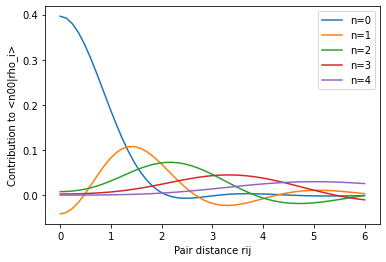

In [39]:
# Start plotting the behavior of the neighbor contribution as a function of the pair distance r_ij
Ndist = 50
dd = np.linspace(0, rcut, Ndist)
coeffs_exact = np.zeros((nmax, Ndist))
for i, d in enumerate(dd):
    coeffs_exact[:,i] = compute_coeffs_explicit_l0(d)


# Make plot
for n in range(nmax):
    plt.plot(dd, coeffs_exact[n], label=f'n={n}')
plt.legend()
plt.xlabel('Pair distance rij')
plt.ylabel('Contribution to <n00|rho_i>')

Remark: This plot was mostly used to make sure that the implementation for small distances $r_{ij} \rightarrow 0$ does indeed converge to the special case $r_{ij}=0$ which is implemented separately.

### Comparison to fully analytical general expression

In [40]:
coeffs_from_general_analytical = np.zeros((nmax, Ndist))
coeffs_from_general_numerical = np.zeros((nmax, Ndist))
for i, d in enumerate(dd):
    coeffs_from_general_analytical[:,i] = coefficients_analytical_general_l(nmax, d, l=0)
    coeffs_from_general_numerical[:,i] = coefficients_semianalytical_general_l(nmax, d, l=0)

<ipython-input-6-5fd5264ad95c>:14: RuntimeWarning: divide by zero encountered in double_scalars
  mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
<ipython-input-6-5fd5264ad95c>:14: RuntimeWarning: invalid value encountered in double_scalars
  mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
<ipython-input-6-5fd5264ad95c>:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  featvec[n] = quad(integrand, eps, 4.5*rcut)[0]


Text(0, 0.5, 'Contribution to <n00|rho_i>')

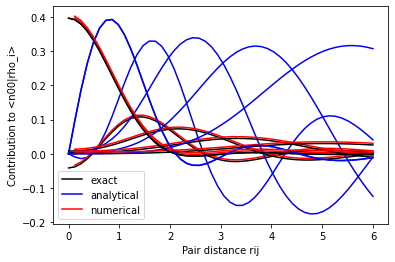

In [41]:
# Make plot
for n in range(nmax):
    plt.plot(dd, coeffs_exact[n], 'k')
    plt.plot(dd, coeffs_from_general_analytical[n], 'b')
    plt.plot(dd, 0.005+coeffs_from_general_numerical[n], 'r')
    
plt.plot(dd, coeffs_exact[0], label=f'exact', c='k')
plt.plot(dd, coeffs_from_general_analytical[0], label=f'analytical', c='b')
plt.plot(dd, 0.01+coeffs_from_general_numerical[0], label=f'numerical', c='r')
plt.legend()
plt.xlabel('Pair distance rij')
plt.ylabel('Contribution to <n00|rho_i>')

Text(0, 0.5, 'Contribution to <n00|rho_i>')

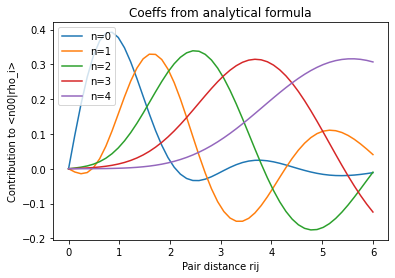

In [42]:
# Make plot of the coefficients obtained from the analytical formula
for n in range(nmax):
    plt.plot(dd, coeffs_from_general_analytical[n], label=f'n={n}')
plt.legend()
plt.title('Coeffs from analytical formula')
plt.xlabel('Pair distance rij')
plt.ylabel('Contribution to <n00|rho_i>')

## Compare exact coefficients with those from pyLODE and Rascal: Center atom contribution <a class="anchor" id="l=0center"></a>

Note that $l=0$ is more complicated compared to $l=1,2,\dots$ even for dimers since the center atom contributes to the density as well. We begin this investigation by using a frame that only consists of a single atom.

### Get the coefficients from the three codes

In [43]:
frames.append(Atoms('O', positions=[[1,1,1]], cell=cell, pbc=True))
frames.append(Atoms('O', positions=[[1,1,1]], cell=1.2*cell, pbc=True))

In [44]:
features_librascal_single = calculator_librascal.transform(frames).get_features(calculator_librascal)[-2:]
calculator_pylode.transform(frames)
features_pylode_single = calculator_pylode.features[-2:]
features_rascaline_single = calculator_rascaline.compute(frames).values[-2:]

### Sanity check 1: Make sure the feature vectors only contain nonzero entries for l=0

In [45]:
features_pylode_single.shape

(2, 1, 5, 36)

In [46]:
features_librascal_single.shape

(2, 180)

In [47]:
features_rascaline_single.shape

(2, 180)

Make sure that the coefficients apart from those at $l=0$ are zero (since we only have a single atom in the structure, the density is spherically symmetric and thus only the $l=0$ projection survives)

In [48]:
for i in range(len(features_pylode_single)):
    # The l=0 coefficients for pyLODE are contained in [n,l]=[:,0]
    feat = features_pylode_single[i,0]
    feat_zero = feat[:,1:]
    assert_allclose(feat_zero, np.zeros_like(feat_zero), atol=1e-7)
    
    # The l=0 coefficients for librascal are separated by (lmax+1)**2
    feat = features_librascal_single[i]
    for n in range(nmax):
        for lm in range((lmax+1)**2):
            if lm != 0:
                assert abs(feat[n*(lmax+1)**2 + lm]) < 1e-8
    
    # The l=0 coefficients of rascaline are the first nmax entries.
    # Thus, all the remaining contributions should be zero.
    feat = np.round(features_rascaline_single[i],15)
    assert_allclose(feat[nmax:], np.zeros_like(feat[nmax:]), atol=1e-8)

### Sanity check 2: Coefficients should be (for pyLODE: mostly) independent of the cell

In [49]:
# For librascal and rascaline, the features should be completely independent of the cell
for feats in [features_librascal_single, features_rascaline_single]:
    feat1 = feats[0]
    feat2 = feats[1]
    assert_allclose(feat1, feat2, rtol=1e-10)

In [50]:
# For pyLODE, the k-space sum does lead to a weak dependence on the cell that depends on
# how well the k-space converged.
feat1 = features_pylode_single[0]
feat2 = features_pylode_single[1]
assert_allclose(feat1, feat2, rtol=1e-10, atol=1e-7)

### Compare pyLODE and rascal coefficients with exact values

In [51]:
feat_pylode_l0_zero = features_pylode_single[0,0,:,0]

In [52]:
coeffs_exact_center = coeffs_exact[:,0] # take the r_{ij} = 0 part

In [53]:
print('Exact center contributions', coeffs_exact_center)

Exact center contributions [ 3.96244980e-01 -4.15614113e-02  7.82924674e-03  2.53274680e-03
  9.21855147e-05]


In [54]:
print('Comparison to pyLODE')
print(feat_pylode_l0_zero / coeffs_exact_center)

Comparison to pyLODE
[0.99999336 0.99992641 1.00036322 0.99855786 1.02418289]


In [55]:
print('Comparison to librascal')
feat_librascal_l0_nonzeropart = features_librascal_single[0,::(lmax+1)**2]
print(feat_librascal_l0_nonzeropart / coeffs_exact_center)

Comparison to librascal
[ 0.08525288  0.23575038  0.0870154  -0.61764874  8.38379227]


In [56]:
feat_librascal_l0_nonzeropart

array([ 0.03378103, -0.00979812,  0.00068127, -0.00156435,  0.00077286])

In [57]:
print('Comparison to rascaline')
feat_rascaline_l0_nonzeropart = features_rascaline_single[0,:nmax]
print(feat_rascaline_l0_nonzeropart / coeffs_exact_center)

Comparison to rascaline
[ 0.93457397  2.58438395  0.95389536 -6.77089664 91.90626852]


Comment: Rascaline seems to exclude the center contribution by default, leading to coefficients that are zero everywhere. This is not an error of the code per se, but is something that should be kept in mind.

## Compare exact coefficients with those from pyLODE and Rascal: Dimers <a class="anchor" id="l=0dimer"></a>

TODO